In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import itertools
import h5py
import os
from scipy.stats import norm
import time

In [23]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

We start by loading a few libraries, either external or from the smFS package. Above this point, you should be checking elsewhere in case anything failed. Below this point, we are to blame. First we modify the path, so that we can actually install the package and load the modules both for running Brownian dynamics and for running kinetics.

In [3]:
import sys
sys.path.append("..")
from smfsmodels import cossio
import kinetics

Now we define a couple of functions, that let us produce 2D-histograms and calculate kinetics.

In [24]:
def pmf2d(xq, qk):
    fig, ax = plt.subplots(figsize=(6,5))
    counts, ybins, xbins, image = ax.hist2d(xk, qk, \
            bins=[np.linspace(-12,12,100), np.linspace(-12,12,100)])
    pmf = -np.log(counts.transpose())
    pmf -= np.min(pmf)
    cs = ax.contourf(pmf, \
            extent=[xbins.min(), xbins.max(), ybins.min(), ybins.max()], \
            cmap=cm.rainbow, levels=np.arange(0,10 ,1))
    cbar = plt.colorbar(cs)
    ax.set_xlim(-12,12)
    ax.set_ylim(-12,12)
    ax.set_xlabel('$x$', fontsize=20)
    ax.set_ylabel('$q$', fontsize=20)
    plt.tight_layout()

In [25]:
def calc_rates(y):
    lifeA, lifeB = kinetics.calc_life([y])
    meanA = 1./np.exp(np.mean(np.log([x for x in lifeA if x>0])))
    meanB = 1./np.exp(np.mean(np.log([x for x in lifeB if x>0])))
    errorA = meanA/np.sqrt(len(lifeA))
    errorB = meanA/np.sqrt(len(lifeB))
    return np.mean([meanA, meanB]), np.mean([errorA, errorB])

In [26]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

#### Molecular potential of mean force 
First we show the molecular potential of mean force on the extension coordinate, $x$, represented by a bistable potential.

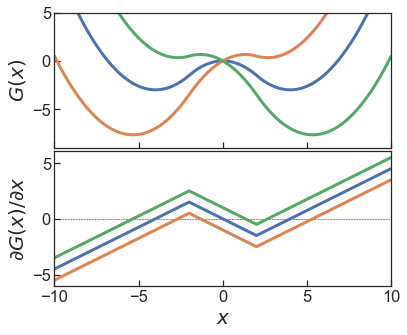

In [27]:
x = np.linspace(-10, 10, 1000)
fig, ax = plt.subplots(2,1, figsize=(6,5), sharex=True)

Gx = [cossio.Gx(y, barrier=3., F12=0) for y in x]
dGqxdx = [cossio.dGqxdx(0, y, barrier=3., F12=0) for y in x]
ax[0].plot(x, Gx, lw=3)
ax[1].plot(x, dGqxdx, lw=3)
Gx = [cossio.Gx(y, barrier=3., F12=-1) for y in x]
dGqxdx = [cossio.dGqxdx(0, y, barrier=3., F12=-1) for y in x]
ax[0].plot(x, Gx, lw=3)
ax[1].plot(x, dGqxdx, lw=3)
Gx = [cossio.Gx(y, barrier=3., F12=1) for y in x]
dGqxdx = [cossio.dGqxdx(0, y, barrier=3., F12=1) for y in x]
ax[0].plot(x, Gx, lw=3)
ax[1].plot(x, dGqxdx, lw=3)

ax[0].set_ylabel('$G(x)$', fontsize=20)
ax[0].set_ylim(-9,5)

ax[1].set_xlabel('$x$', fontsize=20)
ax[1].set_ylabel('$\partial G(x)/\partial x$', fontsize=20)
ax[1].hlines(0, -10, 10, linestyle='dashed', linewidth=0.5)

ax[1].set_xlim(-10,10)
#ax[2].set_ylabel('$\partial^2 G(x)/\partial x^2$', fontsize=20)

plt.tight_layout(h_pad=0.2)

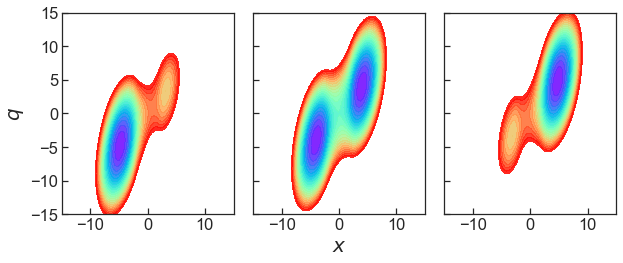

In [42]:
kl = 0.25
x = np.linspace(-15,15,100)
q = np.linspace(-15,15,50)
fig, ax = plt.subplots(1,3, figsize=(9,4), sharex=True, sharey=True)
for ii, f in enumerate([-1,0,1]):
    G2d = np.ones((50, 100), float)*[cossio.Gx(y, barrier=5., F12=f) for y in x]
    for i, j in itertools.product(range(50), range(100)):
        G2d[i,j] += cossio.V(q[i], x[j], kl)
    G2d = np.array(G2d)
    G2d -= np.min(G2d)
    cs = ax[ii].contourf(x, q,  G2d, cmap=cm.rainbow, \
                 levels=np.arange(0,12,0.5), alpha=0.9)
    #cbar = plt.colorbar(cs)
    ax[ii].set_xlim(-15,15)
    ax[ii].set_ylim(-15,15)
ax[1].set_xlabel('$x$', fontsize=20)
ax[0].set_ylabel('$q$', fontsize=20)
plt.tight_layout()

In [43]:
# Globals
dt = 5e-4
Dx = 1. # Diffusion coefficient for molecular coordinate

Next we invoke the `cossio` module to run the dynamics, whose function `run_brownian` will do the job. We are passing a number of input parameters, including the size of the free energy barrier and some variables for IO.

In [57]:
start = time.time()
x, q = [5., 5.]
t, xk, qk = cossio.run_brownian(x0=x, dt=dt, barrier=3., \
                             Dx=Dx, Dq=Dx, F12=-1, numsteps=int(1e8), \
                                fwrite=int(0.01/dt))
end = time.time()
print (end - start)

676.9814550876617


In [58]:
data = np.column_stack((t, xk, qk))
h5file = "data/cossio_kl%g_Dx%g_Dq%g_Fdt%g.h5"%(0, Dx, 0, dt)
try:
    os.makedirs("data")
except OSError:
    pass
with h5py.File(h5file, "w") as hf:
    hf.create_dataset("data", data=data)

Text(0, 0.5, 'x')

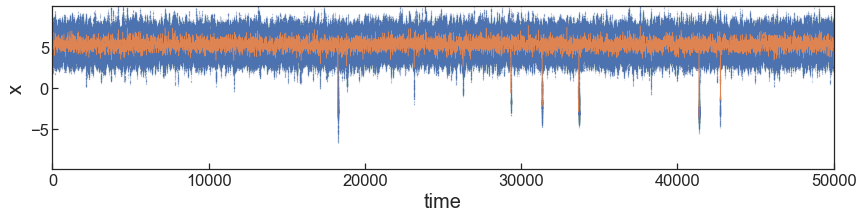

In [59]:
fig, ax = plt.subplots(figsize=(14,3))
ax.plot(t, xk, '.', ms=0.1)
ax.plot(t, smooth(xk, 1000), linewidth=0.5)
ax.set_ylim(-10,10)
ax.set_xlim(0,50000)
ax.set_yticks([-5.,0,5.])
ax.set_xlabel('time', fontsize=20)
ax.set_ylabel('x', fontsize=20)

In [60]:
start = time.time()
x, q = [-5., -5.]
t, xk, qk = cossio.run_brownian(x0=x, dt=dt, barrier=3., \
                             Dx=Dx, Dq=Dx, F12=1, numsteps=int(1e7), \
                                fwrite=int(0.01/dt))
end = time.time()
print (end - start)

65.56785607337952


In [61]:
data = np.column_stack((t, xk, qk))
h5file = "data/cossio_kl%g_Dx%g_Dq%g_Fdt%g.h5"%(0, Dx, 0, dt)
try:
    os.makedirs("data")
except OSError:
    pass
with h5py.File(h5file, "w") as hf:
    hf.create_dataset("data", data=data)

Text(0, 0.5, 'x')

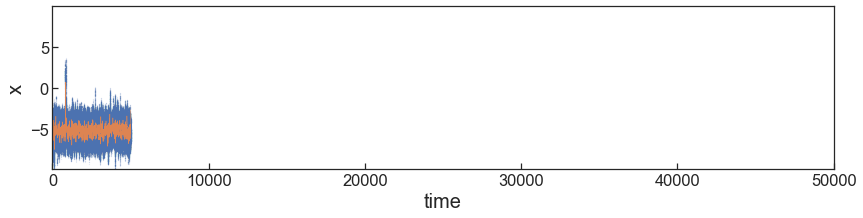

In [62]:
fig, ax = plt.subplots(figsize=(14,3))
ax.plot(t, xk, '.', ms=0.1)
ax.plot(t, smooth(xk, 1000), linewidth=0.5)
ax.set_ylim(-10,10)
ax.set_xlim(0,50000)
ax.set_yticks([-5.,0,5.])
ax.set_xlabel('time', fontsize=20)
ax.set_ylabel('x', fontsize=20)

### Diffusion in two dimensions

In [100]:
x = np.linspace(-10,10,100)
G2d = np.ones((50, 100), float)*[cossio.Gx(y, barrier=5.) for y in x]
q = np.linspace(-12,12,50)
for i, j in itertools.product(range(50), range(100)):
    G2d[i,j] += cossio.V(q[i], x[j], kl)
G2d = np.array(G2d)
G2d -= np.min(G2d)

Text(0, 0.5, '$q$')

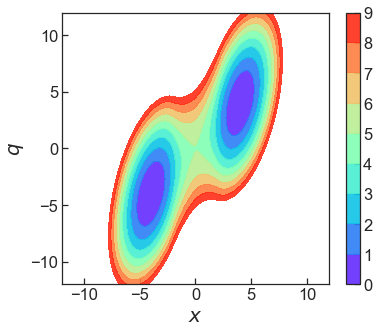

In [101]:
import matplotlib.cm as cm
fig, ax = plt.subplots(figsize=(6,5))
cs = ax.contourf(x, q,  G2d, cmap=cm.rainbow, levels=np.arange(0,10,1), alpha=0.9)
cbar = plt.colorbar(cs)
ax.set_xlim(-12,12)
ax.set_ylim(-12,12)
ax.set_xlabel('$x$', fontsize=20)
ax.set_ylabel('$q$', fontsize=20)

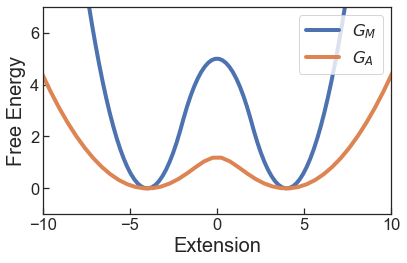

In [102]:
expGM = np.trapz(np.exp(-G2d), q, axis=0)
GM = -np.log(expGM)
expGA = np.trapz(np.exp(-G2d), x, axis=1)
GA = -np.log(expGA)

fig, ax = plt.subplots()
ax.plot(x, GM - np.min(GM), label='$G_M$', lw=4)
ax.plot(q, GA  - np.min(GA), label='$G_A$', lw=4)
#ax.plot(bin_centers, [cossio.Gx(y) for y in bin_centers], '--', c='red', lw=3)
ax.set_xlim(-10,10)
ax.set_ylim(-1,7)
ax.set_xlabel('Extension', fontsize=20)
ax.set_ylabel('Free Energy', fontsize=20)
ax.legend(loc=1)
fig.tight_layout()

In [130]:
x, q = [5., 5.]
t, xk, qk = cossio.run_brownian(x0=x, dt=dt, barrier=5., kl=kl, \
                             Dx=Dx, Dq=Dx, numsteps=int(1e8), fwrite=int(0.1/dt))

(-10, 10)

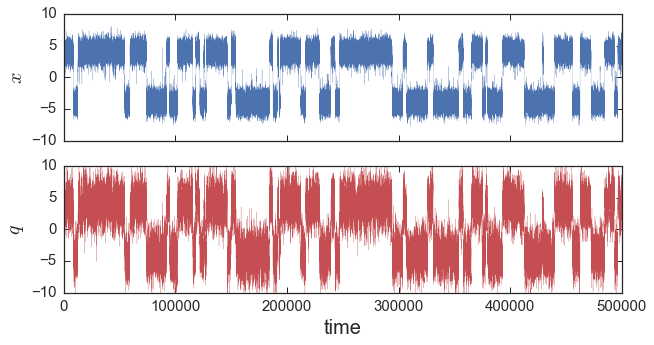

In [131]:
fig, ax = plt.subplots(2,1, figsize=(10,5), sharex=True, sharey=True)
ax[0].plot(xk, linewidth=0.2)
ax[1].plot(qk, 'r', linewidth=0.2)
ax[1].set_xlabel('time', fontsize=20)
ax[1].set_ylabel('$q$', fontsize=20)
ax[0].set_ylabel('$x$', fontsize=20)
ax[0].set_ylim(-10, 10)
#ax[0].set_xlim(0, numsteps)

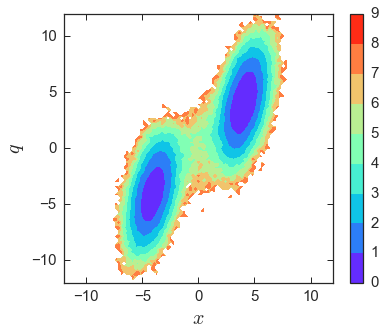

In [132]:
n

In [ ]:
scaling = [5, 2, 1, 0.5, 0.2, 0.1, 0.05, 0.02, 0.01]
nsteps = [1e7, 2e7, 2e7, 2e7, 2e7, 2e7, 2e7, 5e7, 5e7, 5e7]
trajs = {}
for i,sc in enumerate(scaling):
    trajs[sc] = {}
    x, q = [5., 5.]
    numsteps = int(nsteps[i])
    xk, qk = cossio.run_brownian(x0=x, dt=dt, barrier=5., kl=kl, \
                             Dx=Dx, Dq=Dx*sc, numsteps=numsteps, fwrite=100)
    trajs[sc]['x'] = xk
    trajs[sc]['q'] = qk
    
    fig, ax = plt.subplots(2,1, figsize=(10,5), sharex=True, sharey=True)
    ax[0].plot(xk, linewidth=0.2, label='Dx/Dq=%g'%(1./sc))
    ax[1].plot(qk, 'r', linewidth=0.2)
    ax[1].set_xlabel('Time', fontsize=20)
    ax[1].set_ylabel('$q$', fontsize=20)
    ax[0].set_ylabel('$x$', fontsize=20)
    ax[0].set_ylim(-10, 10)
    ax[0].legend(loc=1)

In [ ]:
kfq = []
kfx = []
for i, sc in enumerate(scaling):
    kfx.append(calc_rates(trajs[sc]['x']))
    kfq.append(calc_rates(trajs[sc]['q']))

In [ ]:
fig, ax = plt.subplots()
rates = np.array(kfq)
ax.errorbar(1./np.array(scaling), rates[:,0]/rate0[0], \
            rates[:,1]/rate0[0], marker='o')
ax.set_xscale('log')
ax.set_xlabel('$D_x/D_q$', fontsize=24)
ax.set_ylabel('$k_{MA}/k_M$', fontsize=24)
ax.set_xlim(2e-2,5e2)
plt.tight_layout()

In [ ]:
scaling = [10]
nsteps = [1e8]
for i,sc in enumerate(scaling):
    trajs[sc] = {}
    x, q = [5., 5.]
    numsteps = int(nsteps[i])
    xk, qk = cossio.run_brownian(x0=x, dt=dt/5., barrier=5., kl=kl, \
                             Dx=Dx, Dq=Dx*sc, numsteps=numsteps, fwrite=1000)
    trajs[sc]['x'] = xk
    trajs[sc]['q'] = qk
    
    fig, ax = plt.subplots(2,1, figsize=(10,5), sharex=True, sharey=True)
    ax[0].plot(xk, linewidth=0.2, label='Dx/Dq=%g'%(1./sc))
    ax[1].plot(qk, 'r', linewidth=0.2)
    ax[1].set_xlabel('Time', fontsize=20)
    ax[1].set_ylabel('$q$', fontsize=20)
    ax[0].set_ylabel('$x$', fontsize=20)
    ax[0].set_ylim(-10, 10)
    ax[0].legend(loc=1)

In [ ]:
scaling = [10, 5, 2, 1, 0.5, 0.2, 0.1, 0.05, 0.02, 0.01]
kfq = []
kfx = []
for i, sc in enumerate(scaling):
    #kfx.append(calc_rates(trajs[sc]['x']))
    kfq.append(calc_rates(trajs[sc]['q']))

In [ ]:
fig, ax = plt.subplots()
rates = np.array(kfq)
ax.errorbar(1./np.array(scaling), rates[:,0]/rate0[0], \
            rates[:,1]/rate0[0], marker='o')
ax.set_xscale('log')
ax.set_xlabel('$D_x/D_q$', fontsize=24)
ax.set_ylabel('$k_{MA}/k_M$', fontsize=24)
ax.set_xlim(2e-2,5e2)
plt.tight_layout()